In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from PIL import Image

image_dir = "./MoNuSeg 2018 Training Data/Tissue Images"
xml_dir   = "./MoNuSeg 2018 Training Data/Annotations"
mask_dir  = "dataset/masks"

os.makedirs(mask_dir, exist_ok=True)

def xml_to_mask(xml_path, img_shape):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    h, w = img_shape[0], img_shape[1]
    mask = np.zeros((h, w), dtype=np.uint8)

    for region in root.findall(".//Region"):
        vertices = []
        for vertex in region.findall(".//Vertex"):
            x = float(vertex.attrib['X'])
            y = float(vertex.attrib['Y'])
            vertices.append((int(x), int(y)))
        if len(vertices) > 0:
            pts = np.array(vertices, dtype=np.int32)
            cv2.fillPoly(mask, [pts], color=1)

    return mask

# Loop through images
for fname in os.listdir(image_dir):
    if fname.endswith(".png") or fname.endswith(".jpg") or fname.endswith(".tif"):
        image_path = os.path.join(image_dir, fname)
        xml_path   = os.path.join(xml_dir, fname.replace(".png",".xml").replace(".jpg",".xml").replace(".tif",".xml"))

        if not os.path.exists(xml_path):
            print(f"⚠️ No annotation for {fname}")
            continue

        # Open image to get shape
        img = np.array(Image.open(image_path))
        mask = xml_to_mask(xml_path, img.shape)

        mask_path = os.path.join(mask_dir, fname.replace(".jpg",".png").replace(".tif",".png"))
        Image.fromarray(mask*255).save(mask_path)
        print(f"Saved mask: {mask_path}")


Saved mask: dataset/masks/TCGA-21-5784-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-AR-A1AK-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-MH-A561-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-UZ-A9PN-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-G9-6336-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-50-5931-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-B0-5711-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-G9-6348-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-BC-A217-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-RD-A8N9-01A-01-TS1.png
Saved mask: dataset/masks/TCGA-A7-A13E-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-B0-5698-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-HE-7129-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-NH-A8F7-01A-01-TS1.png
Saved mask: dataset/masks/TCGA-A7-A13F-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-UZ-A9PJ-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-XS-A8TJ-01Z-00-DX1.png
Saved mask: dataset/masks/TCGA-F9-A8NY-01Z-00-DX1.png
Saved mask: dataset/masks/TC

In [56]:
img_size=448

In [57]:
import tensorflow as tf
from glob import glob
from PIL import Image
import numpy as np
import os

# Collect paths (skip "Zone" images)
image_paths = sorted([p for p in glob("./MoNuSeg 2018 Training Data/Tissue Images/*") 
                      if "Zone" not in os.path.basename(p)])
mask_paths  = sorted([p for p in glob("dataset/masks/*") 
                      if "Zone" not in os.path.basename(p)])

print("Images found:", len(image_paths))
print("Masks found:", len(mask_paths))

def _load_numpy(img_path, mask_path, size=(img_size,img_size)):
    # Convert EagerTensor -> bytes -> str
    img_path = img_path.numpy().decode("utf-8")
    mask_path = mask_path.numpy().decode("utf-8")

    img = Image.open(img_path).convert("RGB").resize(size)
    mask = Image.open(mask_path).convert("L").resize(size)

    img = np.array(img, dtype=np.float32) / 255.0
    mask = (np.array(mask) > 127).astype(np.float32)[..., None]  # binarize
    return img, mask

def load_image_mask(img_path, mask_path, size=(img_size,img_size)):
    img, mask = tf.py_function(
        func=_load_numpy, inp=[img_path, mask_path], Tout=[tf.float32, tf.float32]
    )
    img.set_shape([*size, 3])
    mask.set_shape([*size, 1])
    return img, mask

# Build dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(lambda x, y: load_image_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)

Images found: 37
Masks found: 37


In [58]:
import tensorflow as tf

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


In [80]:
import tensorflow as tf
from tensorflow.keras import layers as L, Model

def build_unet(input_shape=(img_size,img_size,3), num_classes=1):
    inputs = L.Input(input_shape)
    c1 = L.SeparableConv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = L.SeparableConv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = L.MaxPooling2D((2,2))(c1)
    c2 = L.SeparableConv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = L.SeparableConv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = L.MaxPooling2D((2,2))(c2)
    c3 = L.SeparableConv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = L.SeparableConv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = L.MaxPooling2D((2,2))(c3)
    c4 = L.SeparableConv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = L.SeparableConv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = L.MaxPooling2D((2,2))(c4)
    c5 = L.SeparableConv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = L.SeparableConv2D(1024, (3,3), activation='relu', padding='same')(c5)
    u6 = L.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    skip4 = L.Conv2D(512, (2,2), padding='same')(c4)   # pointwise conv
    u6 = L.Concatenate()([u6, skip4])
    c6 = L.SeparableConv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = L.SeparableConv2D(512, (3,3), activation='relu', padding='same')(c6)
    u7 = L.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    skip3 = L.Conv2D(256, (1,1), padding='same')(c3)   # pointwise conv
    u7 = L.Concatenate()([u7, skip3])
    c7 = L.SeparableConv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = L.SeparableConv2D(256, (3,3), activation='relu', padding='same')(c7)
    u8 = L.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    skip2 = L.Conv2D(128, (1,1), padding='same')(c2)   # pointwise conv
    u8 = L.Concatenate()([u8, skip2])
    c8 = L.SeparableConv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = L.SeparableConv2D(128, (3,3), activation='relu', padding='same')(c8)
    u9 = L.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    skip1 = L.Conv2D(64, (1,1), padding='same')(c1)    # pointwise conv
    u9 = L.Concatenate()([u9, skip1])
    c9 = L.SeparableConv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = L.SeparableConv2D(64, (3,3), activation='relu', padding='same')(c9)

    if num_classes == 1:
        outputs = L.Conv2D(1, (1,1), activation='sigmoid')(c9)
    else:
        outputs = L.Conv2D(num_classes, (1,1), activation='softmax')(c9)

    return Model(inputs, outputs, name="U-Net-Depthwise-PointSkip")
    
model1 = build_unet(input_shape=(img_size,img_size,3), num_classes=1)
model1.summary()


Model: "U-Net-Depthwise-PointSkip"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5… │ (None, 448, 448,  │        283 │ input_layer_33[0… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5… │ (None, 448, 448,  │      4,736 │ separable_conv2d… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_132   │ (None, 224, 224,  │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5… │ (None, 224, 224,  │      8,896 │ max_pooling2d_13… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5… │ (None, 224, 224,  │     17,664 │ separable_conv2d… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_133   │ (None, 112, 112,  │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5… │ (None, 112, 112,  │     34,176 │ max_pooling2d_13… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5… │ (None, 112, 112,  │     68,096 │ separable_conv2d… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_134   │ (None, 56, 56,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6… │ (None, 56, 56,    │    133,888 │ max_pooling2d_13… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6… │ (None, 56, 56,    │    267,264 │ separable_conv2d… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_135   │ (None, 28, 28,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6… │ (None, 28, 28,    │    529,920 │ max_pooling2d_13… │
│ (SeparableConv2D)   │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6… │ (None, 28, 28,    │  1,058,816 │ separable_conv2d… │
│ (SeparableConv2D)   │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1… │ (None, 56, 56,    │  2,097,664 │ separable_conv2d… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 56, 56,    │  1,049,088 │ separable_conv2d

 Total params: 7,117,916 (27.15 MB)

 Trainable params: 7,117,916 (27.15 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD
bce_loss = BinaryCrossentropy(
    from_logits=False,   
    label_smoothing=0.0, 
    reduction="sum_over_batch_size"     
)
sgd = SGD(
    learning_rate=0.001,   
    momentum=0.95,         
    nesterov=True        
)
# Build & compile
model1 = build_unet(input_shape=(img_size,img_size,3), num_classes=1)
model1.compile(
    optimizer='adam',
    loss=bce_loss,
    metrics=["accuracy", iou_metric, dice_coef]
)

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="loss",     # or "val_loss" if you have validation set
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "unet_best.keras",              
    monitor="iou_metric", 
    mode='max',
    save_best_only=True,         
    save_weights_only=False,     
    verbose=1
)
history = model1.fit(
    dataset,batch_size=8,
    epochs=120,
    callbacks=[reduce_lr, checkpoint]
)


Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7077 - dice_coef: 0.0225 - iou_metric: 0.0115 - loss: 0.6916   
Epoch 1: iou_metric improved from None to 0.00506, saving model to unet_best.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7341 - dice_coef: 0.0099 - iou_metric: 0.0051 - loss: 0.6902 - learning_rate: 0.0010
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7335 - dice_coef: 2.3913e-12 - iou_metric: 2.3913e-12 - loss: 0.6837
Epoch 2: iou_metric did not improve from 0.00506
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.7333 - dice_coef: 2.5595e-12 - iou_metric: 2.5595e-12 - loss: 0.6821 - learning_rate: 0.0010
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.7273 - dice_coef: 2.3532e-12 - iou_metric: 2.3532e-12 - loss: 0.6733
Epoch 3: iou_metric did not improve from 0.00506
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.7333 - dice_coef: 2.5733e-12 - iou_metric: 2.5733e-12 - loss: 0.6706 - learning_rate: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


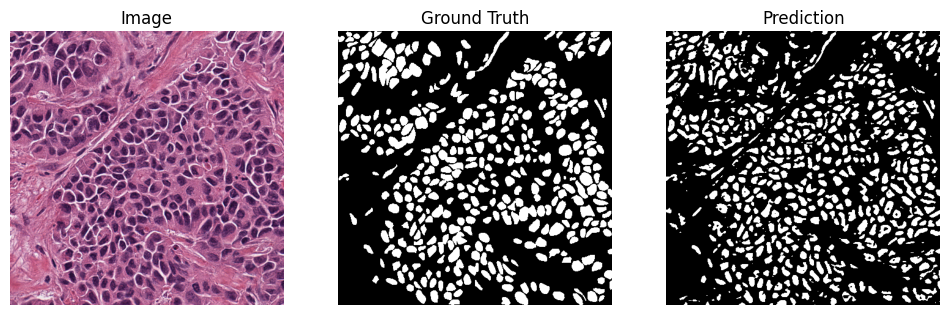

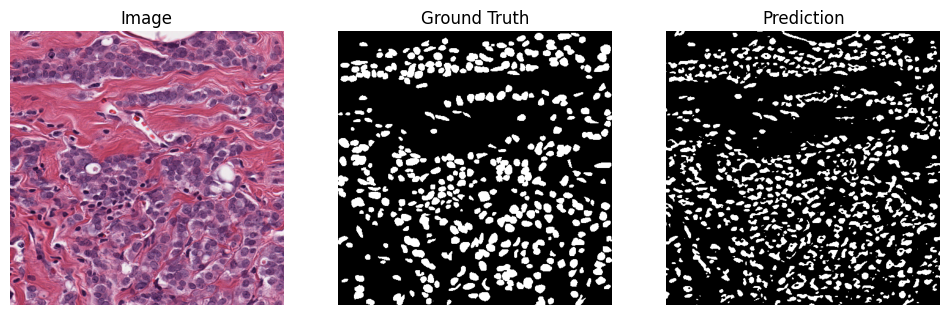

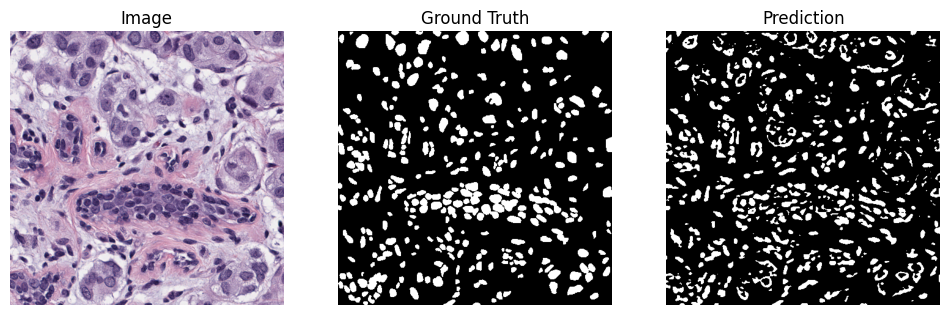

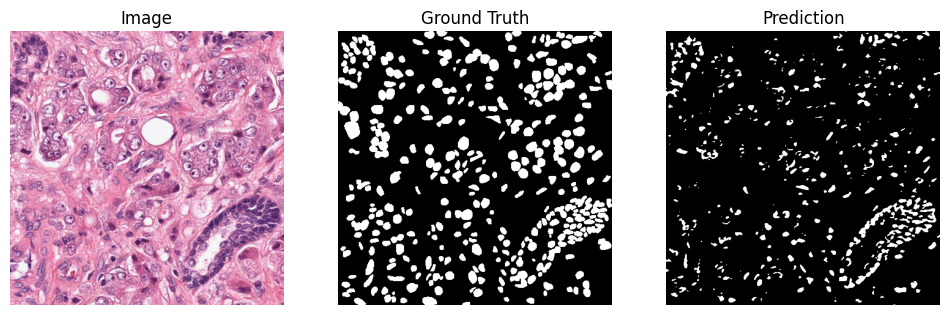

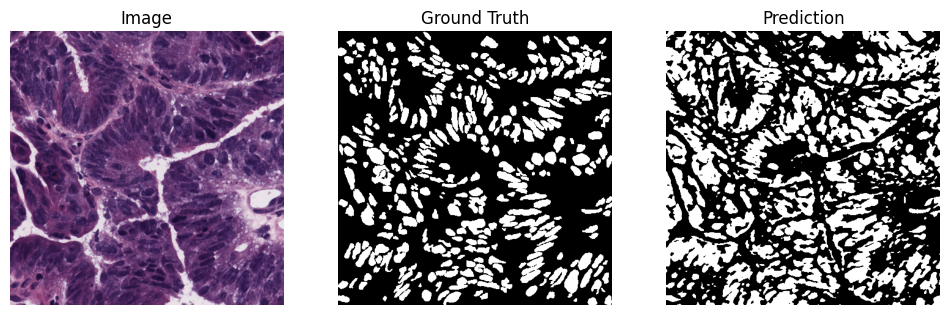

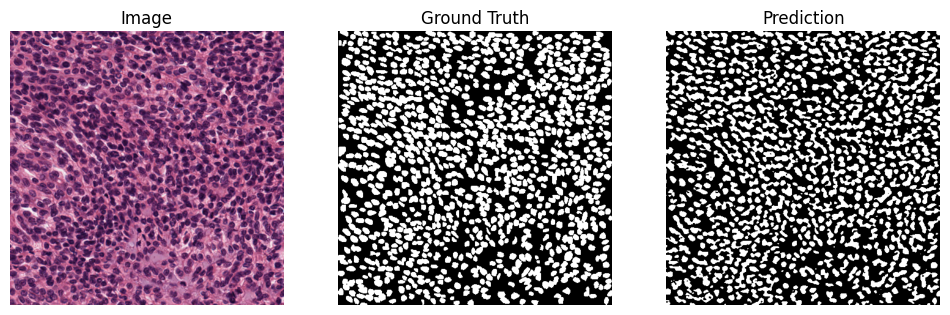

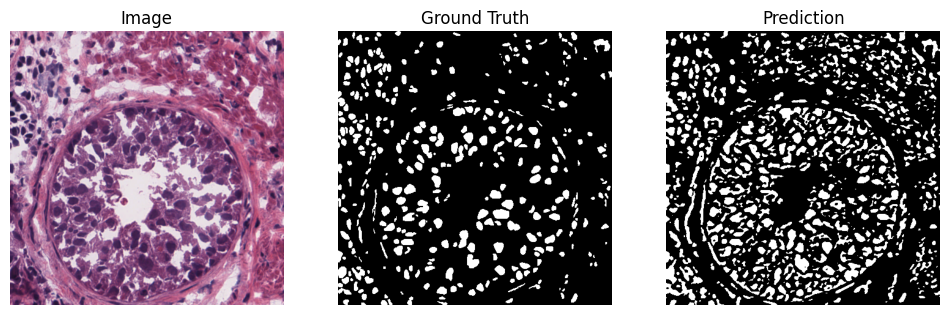

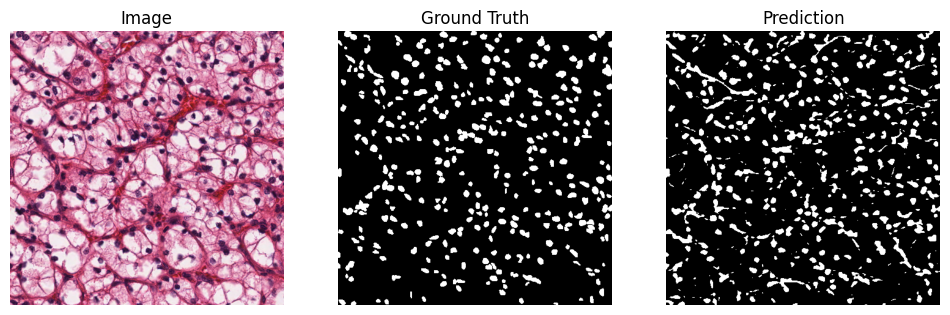

In [84]:
import matplotlib.pyplot as plt

for images, masks in dataset.take(1):
    preds = model1.predict(images)
    preds_bin = (preds > 0.5).astype("float32")
    
    for i in range(8):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(images[i]); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(masks[i].numpy().squeeze(), cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(preds_bin[i].squeeze(), cmap="gray"); plt.title("Prediction"); plt.axis("off")
        plt.show()


In [85]:
ious, dices = [], []
for imgs, masks in dataset:
    preds = model1.predict(imgs)
    ious.append(iou_metric(masks, preds).numpy())
    dices.append(dice_coef(masks, preds).numpy())

print("Mean IoU:", np.mean(ious))
print("Mean Dice:", np.mean(dices))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Mean IoU: 0.5445482
Mean Dice: 0.70450485
